In [255]:
import os
import cv2
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, silhouette_score, make_scorer, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

In [2]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, data_directory, image_size=(256, 256)):
        self.data_directory = data_directory
        self.image_size = image_size
        
    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None, y=None):
        images = []
        labels = []
        # get image labels from the folder names
        class_labels = os.listdir(self.data_directory)
        class_labels.sort()
        # loop through the directory
        for label_idx, class_name in enumerate(class_labels):
            class_dir = os.path.join(self.data_directory, class_name)
            # wrong directory
            if not os.path.isdir(class_dir): 
                continue
            # loop through image files
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                # check for valid image to load
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(file_path)
                    img_resized = cv2.resize(img, self.image_size)
                    if img is not None:
                        images.append(img_resized)  # Store the raw image
                        labels.append(label_idx)  # Store the label as index

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [3]:
class ImageTransform(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(128, 128), to_gray=True, normalize=True):
        self.image_size = image_size
        self.to_gray = to_gray
        self.normalize = normalize

    def set_params(self, **params):
        if 'image_size' in params:
            self.image_size = params['image_size']
        if 'to_gray' in params:
            self.to_gray = params['to_gray']
        if 'normalize' in params:
            self.normalize = params['normalize']
        return self

    def fit(self, X=None, y=None):
        return self

    def transform(self, X):
        transformed_images = []
        # preprocess
        for img in X:
            # resize
            if self.image_size:
                img = cv2.resize(img, self.image_size)
            # grayscale
            if self.to_gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # normalize
            if self.normalize:
                img = img / 255.0  # Normalize to [0,1]
            transformed_images.append(img)
        
        return np.array(transformed_images)

In [4]:
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=500):
        # use opencv SIFT
        self.sift = cv2.SIFT_create()
        self.max_features = max_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sift_features = []
        for img in X:
            # SIFT takes in uint8 format images
            img_uint8 = (img * 255).astype(np.uint8)
            kp, des = self.sift.detectAndCompute(img_uint8, None)
            # features found
            if des is not None:
                des_flattened = des.flatten()
                # descriptors exceed max features truncate
                if len(des_flattened) > self.max_features:
                    des_flattened = des_flattened[:self.max_features]
                # descriptors shorter pad to max features
                else: 
                    des_flattened = np.pad(des_flattened, (0, self.max_features - len(des_flattened)), 'constant')
            # no features found
            else:
                des_flattened = np.zeros(self.max_features)
            sift_features.append(des_flattened)
        return np.array(sift_features)

In [5]:
class FourierFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fft_features = []
        for img in X:
            # fft
            f_transform = np.fft.fft2(img)
            # shift zero frequency to center
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = 20 * np.log(np.abs(f_shift))
            fft_features.append(magnitude_spectrum.flatten())
        return np.array(fft_features)

In [6]:
class SVDReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=200):
        self.n_components = n_components
        self.svd = None

    def fit(self, X, y=None):
        n_components = min(self.n_components, X.shape[1]) # debug for actual reduction
        self.svd = TruncatedSVD(n_components=n_components)
        self.svd.fit(X)
        return self

    def transform(self, X):
        return self.svd.transform(X)

In [139]:
class ClusterEvaluator(BaseEstimator):
    def __init__(self, metric='euclidean'):
        self.metric = metric
        self.silhouette_avg = None
        
    def fit(self, X, y=None):
        return self
    
    def evaluate(self, X, labels):
        # excluding cases with only noise
        if len(set(labels)) > 1 and len(set(labels)) < len(X):
            self.silhouette_avg = silhouette_score(X, labels, metric=self.metric)
        else:
            self.silhouette_avg = -1  # Invalid or trivial clustering

        return self.silhouette_avg
    
    def get_silhouette_score(self):
        return self.silhouette_avg
    
    def set_params(self, **params):
        if 'metric' in params:
            self.metric = params['metric']
        return self
    
    def get_params(self, deep=True):
        return {'metric': self.metric}

In [7]:
# set variable
data_directory = 'data/BigCats'
RANDOM_SEED = 192
# kNN neighbors
number_neighbor = 5
# SVD components
n_components = 200

In [141]:
# data load and split
image_loader = ImageLoader(data_directory=data_directory)
images, labels = image_loader.fit_transform(None)
evaluator = ClusterEvaluator(metric='euclidean')

In [136]:
sift_cluster_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=5)),
    ('scaler', StandardScaler()),
    ('cluster', DBSCAN(eps=1.7, min_samples=5))
])
fourier_cluster_pipeline = Pipeline([
    ('transform', ImageTransform()),
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=5)),
    ('scaler', StandardScaler()),
    ('cluster', DBSCAN(eps=1.7, min_samples=5))
])

In [224]:
param_grid_sift_cluster = {
    'transform__image_size': [(64, 64), (68, 68)],
    'sift__max_features': [100, 120, 130],
    'svd__n_components': [7, 10, 12],
    'cluster__eps': [1.7, 1.8, 1.9],
    'cluster__min_samples': [3, 5, 6]
}

param_grid_fourier_cluster = {
    'transform__image_size': [(64, 64), (128, 128)],
    'svd__n_components': [5, 7, 10, 12],
    'cluster__eps': [1.7, 1.8, 1.9],
    'cluster__min_samples': [3, 5, 6]
}

In [225]:
def silhouette_scorer(estimator, X):
    dbscan_step = sift_cluster_pipeline.named_steps['cluster']
    cluster_labels = dbscan_step.labels_
    
    if 'sift' in estimator.named_steps:
        # SIFT-based pipeline transformations
        X_transformed = estimator.named_steps['transform'].transform(X)
        X_sift = estimator.named_steps['sift'].transform(X_transformed)
        X_svd = estimator.named_steps['svd'].transform(X_sift)
        X_scaled = estimator.named_steps['scaler'].transform(X_svd)
    
    elif 'fourier' in estimator.named_steps:
        # Fourier-based pipeline transformations
        X_transformed = estimator.named_steps['transform'].transform(X)
        X_fourier = estimator.named_steps['fourier'].transform(X_transformed)
        X_svd = estimator.named_steps['svd'].transform(X_fourier)
        X_scaled = estimator.named_steps['scaler'].transform(X_svd)
    
    else:
        raise ValueError("Pipeline must contain either 'sift' or 'fourier' step.")
    
    
    # Check if lengths match
    if len(cluster_labels) != len(X_scaled):
        return np.nan
    
    # Calculate silhouette score
    score = evaluator.evaluate(X_scaled, cluster_labels)
    return score

In [242]:
def fit_with_grid(pipeline, param_grid, images): 
    best = {}
    best_score = -np.inf  # Initialize best score
    
    print(f"\nRunning Grid Search:")
    
    for params in ParameterGrid(param_grid):
        # Set parameters for the pipeline
        pipeline.set_params(**params)
        
        # Fit the pipeline to the full dataset (no cross-validation)
        pipeline.fit(images)
        
        # Get the silhouette score
        score = silhouette_scorer(pipeline, images)
        
        # Update best model if current score is better
        if score > best_score:
            best_score = score
            best_model = pipeline
            best_image_size = pipeline.named_steps['transform'].image_size
            best_params = params
            best_labels = labels
    
    # Print best model details
    print(f"Best Model: {best_model}")
    print(f"Best silhouette score: {best_score}")
    print(f"Best image size: {best_image_size}")
    
    # Store and return the best results
    best = {
        'best_image_size': best_image_size, 
        'best_model': best_model,
        'best_silhouette': best_score, 
        'best_params': best_params, 
        'predicted_labels': best_labels
    }
    return best

In [243]:
print("\nFitting SIFT + DBSCAN: ")
best_sift_dbscan = fit_with_grid(sift_cluster_pipeline, param_grid_sift_cluster, images)

print("\nFitting Fourier + DBSCAN")
best_fourier_dbscan = fit_with_grid(fourier_cluster_pipeline, param_grid_fourier_cluster, images)


Fitting SIFT + DBSCAN: 

Running Grid Search:
Best Model: Pipeline(steps=[('transform', ImageTransform(image_size=(68, 68))),
                ('sift', SIFTFeatureExtractor(max_features=130)),
                ('svd', SVDReducer(n_components=12)),
                ('scaler', StandardScaler()),
                ('cluster', DBSCAN(eps=1.9, min_samples=6))])
Best silhouette score: 0.1726846545934677
Best image size: (68, 68)

Fitting Fourier + DBSCAN

Running Grid Search:
Best Model: Pipeline(steps=[('transform', ImageTransform()),
                ('fourier', FourierFeatureExtractor()),
                ('svd', SVDReducer(n_components=12)),
                ('scaler', StandardScaler()),
                ('cluster', DBSCAN(eps=1.9, min_samples=6))])
Best silhouette score: -1
Best image size: (64, 64)


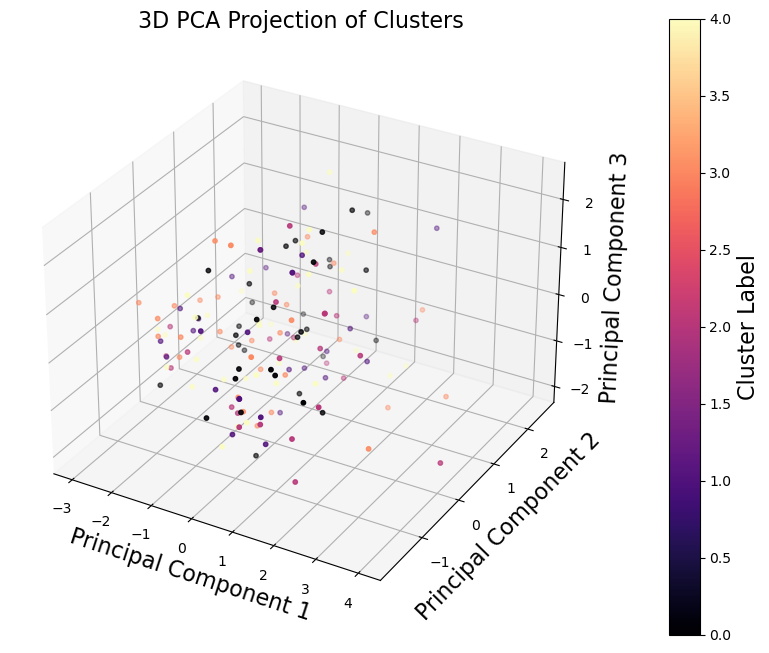

In [241]:
pca = PCA(n_components=3)
best_params = best_sift_dbscan['best_params']
sift_cluster_pipeline.set_params(**best_params)
X_transformed = sift_cluster_pipeline.named_steps['scaler'].transform(
    sift_cluster_pipeline.named_steps['svd'].transform(
        sift_cluster_pipeline.named_steps['sift'].transform(
            sift_cluster_pipeline.named_steps['transform'].transform(images)
        )
    )
)

projected = pca.fit_transform(X_transformed)

# Plot the 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=labels, cmap='magma', s=10)

# Add colorbar and labels
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Label', fontsize=16)
ax.set_title("3D PCA Projection of Clusters", fontsize=16)
ax.set_xlabel("Principal Component 1", fontsize=16)
ax.set_ylabel("Principal Component 2", fontsize=16)
ax.set_zlabel("Principal Component 3", fontsize=16)
plt.savefig("figures/cluster_projection_3d.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

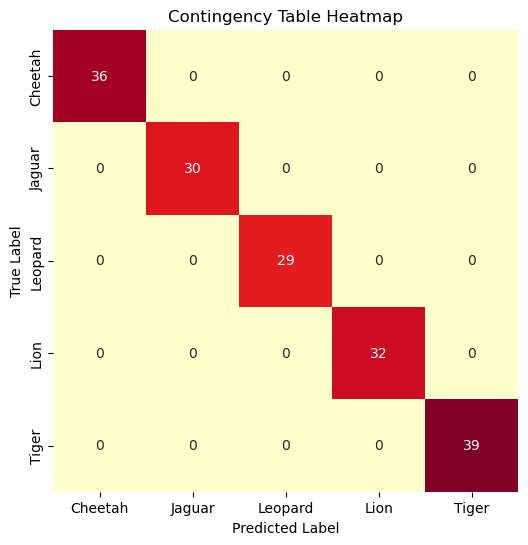

In [260]:
class_names = {0: 'Cheetah', 1: 'Jaguar', 2: 'Leopard', 3: 'Lion', 4: 'Tiger'}
true_labels = labels
predicted_labels = best_sift_dbscan['predicted_labels']

# contingency table
contingency_table = pd.crosstab(pd.Series(true_labels, name='True Label'), 
                                pd.Series(predicted_labels, name='Predicted Label'))
plt.figure(figsize=(6, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlOrRd", cbar=False, xticklabels=[class_names[i] for i in range(len(class_names))],
            yticklabels=[class_names[i] for i in range(len(class_names))])
plt.title("Contingency Table Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("figures/cluster_contingency_map.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()